In [629]:
# Initialize Otter
import otter
grader = otter.Notebook("hw11.ipynb")

# Homework 11: Principal Component Analysis

In lecture we discussed how PCA can be used for dimensionality reduction. Specifically, given a high dimensional dataset, PCA allows us to:
1. Understand the rank of the data. If $k$ principal components capture almost all of the variance, then the data is roughly rank $k$.
2. Create 2D scatterplots of the data. Such plots are a rank 2 representation of our data, and allow us to visually identify clusters of similar observations.
3. Create other low rank approximations of the data. Other than the 2D scatterplots mentioned above, this is something we won't really do in Data 100.

A solid geometric understanding of PCA will help you understand why PCA is able to do these three things. In this homework, we'll build that geometric intuition and look at PCA on two datasets: one where PCA works poorly, and the other where it works pretty well.

## Due Date

This assignment is due **Thursday, April 29th at 11:59 PM PDT**.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Collaborators:** ...

## Score Breakdown

Question | Points
--- | ---
Question 1a | 1
Question 1b | 1
Question 1c | 1
Question 1d | 1
Question 1e | 1
Question 2a | 2
Question 2b | 1
Question 2c | 1
Question 2d | 3
Question 2e | 2
Question 3a | 1
Question 3b | 2
Question 3c | 1
Question 3d | 1
Question 3e | 2
Question 3f | 2
Question 3g | 2
Question 3h | 1
Question 3i | 2
Question 3j | 2
Question 4a | 1
Question 4b | 2
Total | 33

In [630]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

# Note: If you're having problems with the 3d scatter plots, uncomment the two lines below, and you should see a version that 
#      number that is at least 4.1.1.
# import plotly
# plotly.__version__

## Question 1: PCA on 3D Data

**In question 1, our goal is to see visually how PCA is simply the process of rotating the coordinate axes of our data.**

The code below reads in a 3D dataset. We have named the variable `surfboard` because the data resembles a surfboard when plotted in 3D space.

In [631]:
surfboard = pd.read_csv("data3d.csv")
surfboard.head(5)

,x,y,z
0,0.005605,2.298191,1.746604
1,-1.093255,2.457522,0.170309
2,0.060946,0.473669,-0.003543
3,-1.761945,2.151108,3.132426
4,1.950637,-0.194469,-2.101949


The cell below will allow you to view the data as a 3D scatterplot. Rotate the data around and zoom in and out using your trackpad or the controls at the top right of the figure.

You should see that the data is an ellipsoid that looks roughly like a surfboard or a [hashbrown patty](https://www.google.com/search?q=hashbrown+patty&source=lnms&tbm=isch). That is, it is pretty long in one direction, pretty wide in another direction, and relatively thin along its third dimension. We can think of these as the "length", "width", and "thickness" of the surfboard data.

Observe that the surfboard is not aligned with the x/y/z axes.

If you get an error that your browser does not support webgl, you may need to restart your kernel and/or browser.

In [632]:
fig = px.scatter_3d(surfboard, x='x', y='y', z='z', range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10])
fig.show()

To give the figure a little more visual pop, the following cell does the same plot, but also assigns a pre-determined color value (that we've arbitrarily chosen) to each point. These colors do not mean anything important, they're simply there as a visual aid.

You might find it useful to use `colorize_surfboard_data` later in this assignment.

In [633]:
def colorize_surfboard_data(df):
    colors = pd.read_csv("surfboard_colors.csv", header = None).values
    df_copy = df.copy()
    df_copy.insert(loc = 3, column = "color", value = colors)
    return df_copy
    
fig = px.scatter_3d(colorize_surfboard_data(surfboard), x='x', y='y', z='z', range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10], color = "color", color_continuous_scale = 'RdBu')
fig.show()

## Question 1a

Now that we've understood the data, let's work on understanding what PCA will do when applied to this data.

To properly perform PCA, we will first need to "center" the data so that the mean of each feature is 0. 

Compute the columnwise mean of `surfboard` in the cell below, and store the result in `surfboard_mean`. You can choose to make `surfboard_mean` a numpy array or a series, whichever is more convenient for you. Regardless of what data type you use, `surfboard_mean` should have 3 means, 1 for each attribute, with the x coordinate first, then y, then z.

Then, subtract `surfboard_mean` from `surfboard`, and save the result in `surfboard_centered`. The order of the columns in `surfboard_centered` should be x, then y, then z.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [634]:
surfboard_mean = np.mean(surfboard, axis=0)
surfboard_centered = surfboard - surfboard_mean
surfboard_centered

,x,y,z
0,-0.022232,2.264900,1.766968
1,-1.121093,2.424231,0.190672
2,0.033108,0.440379,0.016820
3,-1.789782,2.117818,3.152790
4,1.922799,-0.227760,-2.081586
...,...,...,...
995,2.020137,-0.893329,-2.254221
996,-1.352248,-0.466080,1.456764
997,-0.167351,-0.719878,-1.860545
998,-1.675548,-0.231013,0.731038


In [635]:
grader.check("q1a")

q1a passed!

## Question 1b

As you may recall from lecture, PCA is a specific application of the singular value decomposition (SVD) for matrices. If we have a data matrix $X$, we can decompose it into $U$, $\Sigma$ and $V^T$ such that $X = U \Sigma V^T$. Here, $U$ contains the left singular vectors, $\Sigma$ is a diagonal matrix containing the singular values, and $V^T$ contains the right singular vectors.

In the following cell, use the [`np.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) function to compute the SVD of `surfboard_centered`. Store the left singular vectors, singular values, and right singular vectors in `u`, `s`, and `vt` respectively. This is one line of simple code, exactly like what we saw in lecture.

**Hint:** Set the `full_matrices` argument of `np.linalg.svd` to `False`.

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [636]:
u, s, vt = np.linalg.svd(surfboard_centered, full_matrices = False)
u, s, vt

(array([[-0.02551985, -0.02108339, -0.03408865],
        [-0.02103979, -0.0259219 ,  0.05432967],
        [-0.00283413, -0.00809889,  0.00204459],
        ...,
        [ 0.01536972, -0.00483066,  0.05673824],
        [-0.00917593,  0.0345672 ,  0.03491181],
        [-0.01701236,  0.02743128, -0.01966704]]),
 array([103.76854043,  40.38357469,  21.04757518]),
 array([[ 0.38544534, -0.67267377, -0.63161847],
        [-0.5457216 , -0.7181477 ,  0.43180066],
        [-0.74405633,  0.17825229, -0.64389929]]))

In [637]:
grader.check("q1b")

q1b passed!

## Question 1c: Total Variance

Let's now consider the relationship between the singular values `s` and the variance of our data. Recall that the total variance is the sum of the variances of each column of our data. Below, we provide code that computes the variance for each column of the data.

Note: The variances are the same for both `surfboard_centered` and `surfboard`, so we show only one to avoid redundancy.

In [638]:
np.var(surfboard, axis=0)

x    2.330704
y    5.727527
z    4.783513
dtype: float64

The total variance of our dataset is given by the sum of these numbers.

In [639]:
total_variance_computed_from_data = sum(np.var(surfboard, axis=0))
total_variance_computed_from_data

12.841743509780109

As discussed in lecture, the total variance of the data is also equal to the sum of the squares of the singular values divided by the number of data points, that is:

$$Var(X) = \frac{\sum_{i=1}^d{\sigma_i^2}}{N}$$

where $\sigma_i$ is the singular value corresponding to the i'th principal component and $N$ is the total number of data points.

In the cell below, compute the total variance using the the formula above and store the result in the variable `total_variance_computed_from_singular_values`. Your result should be very close to `total_variance_computed_from_data`.

<!--
BEGIN QUESTION
name: q1c
points: 1
-->

In [640]:
total_variance_computed_from_singular_values = np.sum(s**2)/ u.shape[0]
total_variance_computed_from_singular_values

12.841743509780104

In [641]:
grader.check("q1c")

q1c passed!

## Question 1d: Explained Variance and Scree Plots

In the cell below, set `variance_explained_by_1st_pc` to the proportion of the total variance explained by the 1st principal component. Your answer should be a number between 0 and 1.

Note: This topic was discussed in [this section of the PCA lecture slides](https://docs.google.com/presentation/d/1mk9g45VZP8U-9cLCke72aPB1Ve1D8LvpKsPX2Ix-VX4/edit?usp=sharing).

<!--
BEGIN QUESTION
name: q1d
points: 1
-->

In [642]:
variance_explained_by_1st_pc = (total_variance_computed_from_singular_values) / (total_variance_computed_from_data)
variance_explained_by_1st_pc

0.9999999999999996

In [643]:
grader.check("q1d")

q1d passed!

We can also create a scree plot that shows the variance explained by all of our principal components, ordered from most to least. An example scree plot is given below. Here the y-axis is the amount of variance explained by the ith principal component.

Text(0.5, 1.0, 'Variance Explained by each Principal Component')

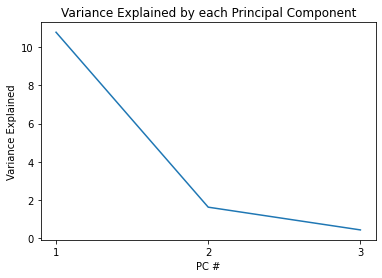

In [644]:
plt.plot([1, 2, 3], (s**2 / len(surfboard_centered)));
plt.xticks([1, 2, 3], [1, 2, 3]);
plt.xlabel('PC #');
plt.ylabel('Variance Explained');
plt.title('Variance Explained by each Principal Component')

If we divide by the total variance, we can get the fraction explained by each component. Note that the variance explained by the first principal component matches the value we calculated above for `variance_explained_by_1st_pc`.

Note: If you're wondering where `len(surfboard_centered)` went, it got canceled out when we divided the variance of a given PC by the total variance.

Text(0.5, 1.0, 'Fraction of Variance Explained by each Principal Component')

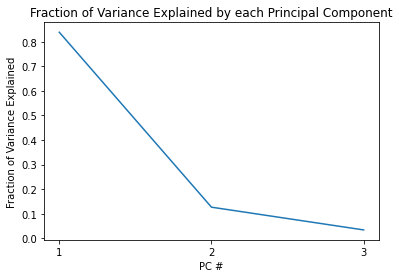

In [645]:
plt.plot([1, 2, 3], s**2 / sum(s**2));
plt.xticks([1, 2, 3], [1, 2, 3]);
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance Explained');
plt.title('Fraction of Variance Explained by each Principal Component')

For this small toy problem, the scree plot is not particularly useful. We'll see why they are useful in practice later in this homework. 

## Question 1e: V as a Rotation Matrix

In lecture, we saw that the first column of $U \Sigma$ contained the first principal component values for each observation, the second column of $U \Sigma$ contained the second principal component values for each observation, and so forth.

Let's give this matrix a name: $P = U \Sigma$ is sometimes known as the "principal component matrix".

The code below computes $P$ using $U$ and $\Sigma$, then prints out the principal components for the 5th observation in the dataset.

In [646]:
P = u @ np.diag(s)
print(f"The 5th observation in x/y/z is: {surfboard.iloc[4, 0]}, {surfboard.iloc[4, 1]}, {surfboard.iloc[4, 2]}")
print(f"The 1st, 2nd, and 3rd pcs of our 5th observation are: {P[4, 0]}, {P[4, 1]}, {P[4, 2]}")

The 5th observation in x/y/z is: 1.950637304600804, -0.1944692091869376, -2.1019492971930087
The 1st, 2nd, and 3rd pcs of our 5th observation are: 2.209110214853995, -1.784578358906229, -0.13093802139261504


Sometimes, $V^T$ is known as the "loadings matrix". In the cell below, we show $V^T$.

$V^T$ gives us a way to convert our data into principal component values. For example, since the first row of $V^T$ is $[0.39, -0.67, -0.63]$, we can calculate the first principal component value for a given observation $[x, y, z]$ from the following equation:

$$\text{PC 1} = 0.38x - 0.67y - 0.63z$$

Thus, the value of the first principal component for the 5th observation is

$$0.39(1.95) + 0.67(0.19) + 0.63(2.1) = 2.21$$.

Another way to think about $V$ is that it is a rotation matrix that transforms our original data matrix $X$ (through rotation) into $P$. This is given by the simple relationship that $P = XV$, which we prove below:

Proposition: $P = XV$

Proof: 

1. Because $X = U \Sigma V^T$, we have that $X = P V^T$.
2. As discussed in [lecture 22](https://docs.google.com/presentation/d/1mk9g45VZP8U-9cLCke72aPB1Ve1D8LvpKsPX2Ix-VX4/edit?usp=sharing), one special property of $V^T$ is that its inverse is also its transpose.
3. Thus if we multiply both sides of $X = P V^T$, we get $XV = P V^T V$. Since $V^T V$ is the identity matrix, we have $XV = P$.

In other words, another way to compute our principal component matrix $P$ is $P = XV$. In the cell below, compute P using the centered surfboard data and $V$. Assign the result to a variable called `surfboard_pcs`.

*Hint*: In python, you can use `.T` to form the transpose of a numpy array. For example `u.T` is equivalent to saying $U^T$.

<!--
BEGIN QUESTION
name: q1e
points: 1
-->

In [647]:
surfboard_pcs = surfboard_centered @ vt.T
surfboard_pcs

,0,1,2
0,-2.648158,-0.851423,-0.717483
1,-2.183269,-1.046819,1.143508
2,-0.294094,-0.327062,0.043034
3,-4.105824,0.817194,-0.320874
4,2.209110,-1.784578,-0.130938
...,...,...,...
995,2.803379,-1.434264,-0.210842
996,-1.127817,1.701696,-0.014940
997,1.594893,-0.195079,1.194202
998,-0.952173,1.395947,0.734809


In [648]:
grader.check("q1e")

q1e passed!

## Visualizing the Principal Component Matrix

In some sense, we can think of $P$ as an output of the PCA procedure. 

It is simply a rotation of the data such that the data will now appear "axis aligned". Specifically, for a 3d dataset, if we plot pc1, pc2, and pc3 along the x, y, and z axes of our plot, then the greatest amount of variation happens along the x-axis, the second greatest amount along the y-axis, and the smallest amount along the z-axis. 

To visualize this, run the cell below, which will show our data now projected onto the principal component space. Compare with your original figure, and observe that the data is exactly the same, only it is now rotated.

In [649]:
surfboard_pcs = surfboard_pcs.rename(columns = {0: "pc1", 1: "pc2", 2: "pc3"})
fig = px.scatter_3d(colorize_surfboard_data(surfboard_pcs), 
                    x='pc1', y='pc2', z='pc3', range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10], color = 'color', color_continuous_scale = 'RdBu');
fig.show();

Recall in lecture that we created a scatter plot of only the first two principal components of congressional data. We can do that here with our surfboard data as well.

Note that the resulting is just the 3D plot as viewed from directly "overhead".

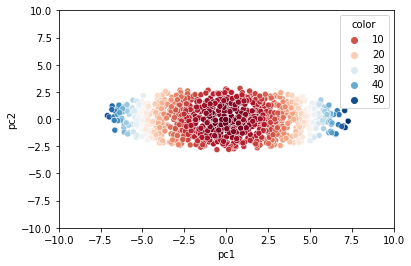

In [650]:
sns.scatterplot(data = colorize_surfboard_data(surfboard_pcs), x = 'pc1', y = 'pc2', hue = "color", palette = "RdBu")
plt.gca().set_xlim(-10, 10);
plt.gca().set_ylim(-10, 10);

## Question 1 Summary

Above, we saw that the principal component matrix $P$ is simply the original data rotated in space so that it appears axis-aligned.

We also saw that $P$ can be computed as $P = U\Sigma$ or equivalently as $P = XV$.

Whenever we do a 2D scatter plot of only the first 2 columns of $P$, we are simply looking at the data from "above", i.e. so that the 3rd (or higher) PC is invisible to us.

## Question 2

Let's try out PCA on a higher dimensional dataset. 

In this question, we'll look at a sheet containing Midterm 1 grades from Data 100 in Fall 2019. As it turns out, PCA scatterplots won't be particularly useful on this dataset, but we'll learn some important things along the way.

**Specifically, we'll have 3 primary goals in question 2: we will see what a 2D scatter plot of high dimensional data looks like, we will try to  interpret the meaning of our principal components, and we will see why normalizing column variance can be important.**

Note: These grades are a snapshot of the grades before the TAs were done grading. Any problem which hadn't been graded at the time was given a score of 0.

In [651]:
mid1_grades = pd.read_csv("fa19mid1.csv")
mid1_grades.head()

,1.1: 1a (1.0 pts),1.2: 1b (3.0 pts),1.3: 1c i (1.0 pts),1.4: 1c ii (1.0 pts),1.5: 1c iii (1.0 pts),1.6: 1d (6.0 pts),1.7: 1e (8.0 pts),1.8: 1f (2.0 pts),1.9: 1g (2.0 pts),2.1: 2a (2.0 pts),...,5.2: 5a ii (3.0 pts),5.3: 5b i (3.0 pts),5.4: 5b ii (3.0 pts),5.5: 5c (2.0 pts),6.1: 6a i (2.0 pts),6.2: 6a ii (2.0 pts),6.3: 6b i (3.0 pts),6.4: 6b ii (4.0 pts),6.5: 6b iii (3.0 pts),6.6: 6c (4.0 pts)
0,0,3.0,0.5,0,0.5,6,3,2,2,2,...,1,0.0,0,2,1,2,3,1,2,0
1,0,3.0,1.0,0,0.0,6,2,2,0,2,...,0,3.0,3,0,2,2,3,0,2,0
2,1,3.0,1.0,1,1.0,6,7,2,2,2,...,1,2.0,3,2,2,2,3,4,3,0
3,0,2.0,1.0,0,0.5,6,8,2,2,2,...,1,3.0,0,2,1,2,3,1,0,0
4,1,3.0,1.0,1,0.5,6,6,1,0,2,...,3,2.0,3,0,2,2,3,1,2,4


This is 31 dimensional data, with each row of the table representing the scores of a given student. This data has far too many dimensions for us to be able to plot all of the data at once.

One approach is to create a bunch of 2D scatterplots, one for each pair of variables. For example, the cell below generates scatterplots for each of the 5 problems about visualizations.

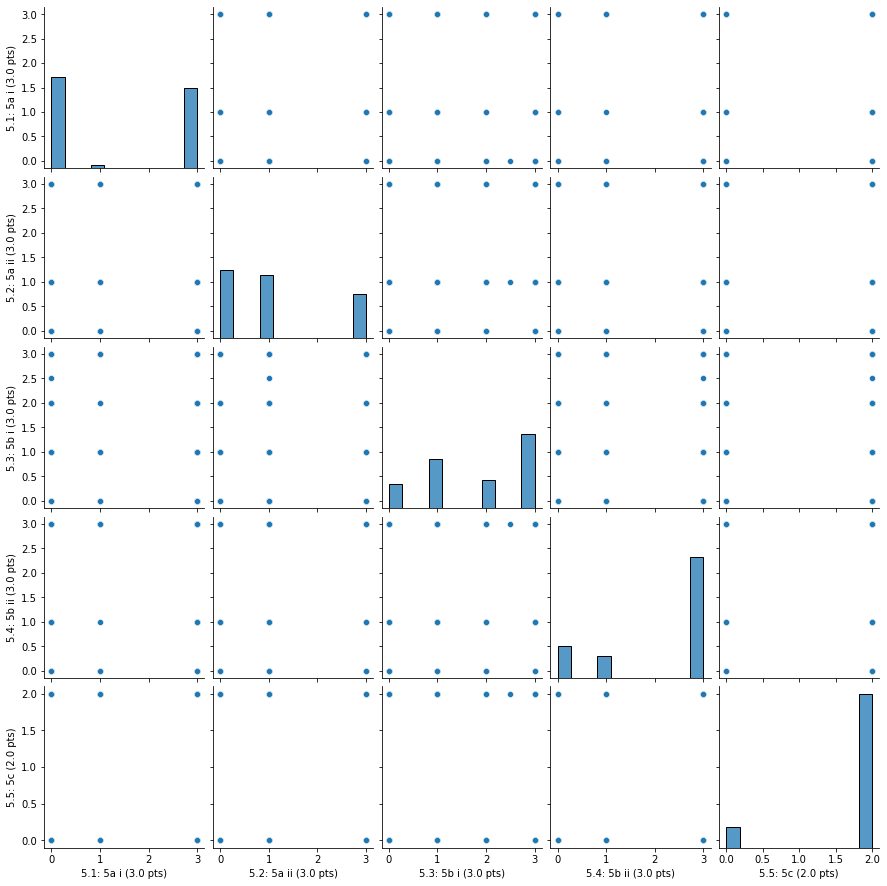

In [652]:
sns.pairplot(mid1_grades.loc[:, '5.1: 5a i (3.0 pts)':'5.5: 5c (2.0 pts)']);

Unfortunately, due to overplotting, the plot above isn't very informative.

To address overplotting, we can add a little bit of noise. The resulting visualization still isn't great, but we can at least learn a few things, e.g. among students who got 1 point on problem 5b.ii, only one of those students also got 1 point on problem 5a.i.

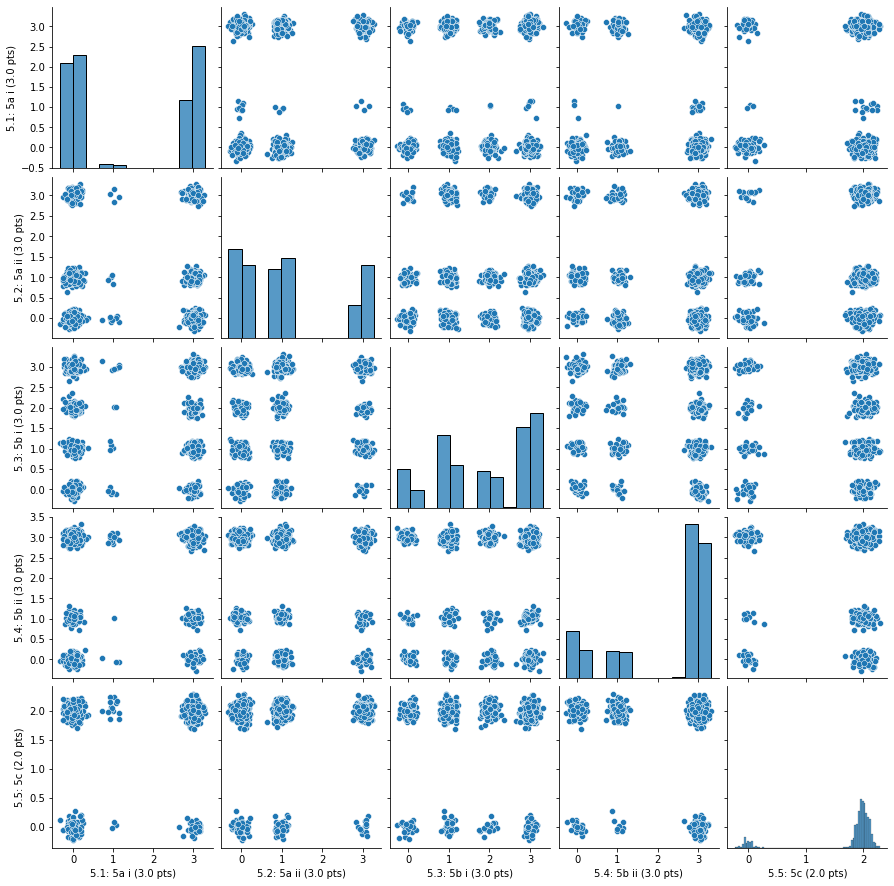

In [653]:
sns.pairplot(mid1_grades.loc[:, '5.1: 5a i (3.0 pts)':'5.5: 5c (2.0 pts)'] + np.random.normal(0, 0.1, size = (len(mid1_grades), 5)));

## Question 2a

Using PCA, we can try to visualize student performance on ALL questions simultaneously. In the cell below, create a **DataFrame** called `mid1_1st_2_pcs` that has 992 rows and 2 columns, where the first column is named `pc1` and represents the first principal component, and the second column is named `pc2` and represents the second principal component. The columns of your dataframe should be named `pc1` and `pc2`.

Reminder: make sure to center your data first!

<!--
BEGIN QUESTION
name: q2a
points: 2
-->

In [654]:
mid1_mean = np.mean(mid1_grades, axis=0)
mid1_centered = mid1_grades - mid1_mean
u2, s2, vt2, = np.linalg.svd(mid1_centered, full_matrices = False)
mid1_pcs = pd.DataFrame(u2*s2)[[0,1]].rename(columns = {0: 'pc1', 1: 'pc2'})
mid1_1st_2_pcs = mid1_pcs
mid1_1st_2_pcs

,pc1,pc2
0,1.710289,-3.488682
1,1.984097,-1.912580
2,-3.866735,-0.610573
3,-4.045114,-3.764690
4,-3.543188,1.755030
...,...,...
987,-3.845434,-1.906045
988,3.008503,-0.786646
989,1.855954,-0.596268
990,-0.472896,1.611815


In [655]:
grader.check("q2a")

q2a passed!

## Question 2b

In the cell below, we create a 2d scatterplot of the first two principal components of the data. Observe that the plot appears to have some sort of structure: The data shows diagonal bands. We will not explore the reasons for these diagonal bands, but we leave this as an optional exercise (Q5) at the very end of the homework if you're curious.

As with the surfboard data, we have assigned arbitrary colors to each student as a visual aid. There is no special meaning to the colors.

In [656]:
def colorize_midterm_data(df):
    """Adds a color column to the given midterm data."""
    colors = pd.read_csv("mid1_colors.csv", header = None).values
    df_copy = df.copy()
    df_copy.insert(loc = 0, column = "color", value = colors)
    return df_copy

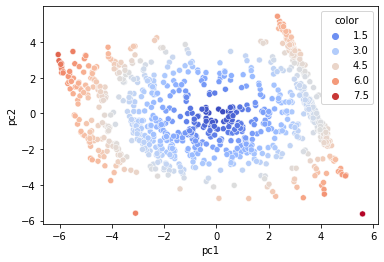

In [657]:
sns.scatterplot(data = colorize_midterm_data(mid1_1st_2_pcs), x = "pc1", y = "pc2", hue = "color", palette = "coolwarm");

This is a 2D plot of 31 dimensional data. To get a sense of how much of the story we're capturing, in the cell below, give the proportion of the variance accounted for by the first two principal components. Give your answer exactly. It should be around 39%.

<!--
BEGIN QUESTION
name: q2b
points: 1
-->

In [658]:
ds100_mt1_1st_2_pc_variance_fraction = np.round(s2**2/sum(s2**2),2)[0] + np.round(s2**2/sum(s2**2),2)[1]
ds100_mt1_1st_2_pc_variance_fraction

0.39

In [659]:
grader.check("q2b")

q2b passed!

## Question 2c

While the plot above captures around 39% of the variance, it's hard to interpret. One approach is to do something similar to what we did during lecture where we plotted how much each column of our data contributes to each principal component.

The function defined in the cell below plots and labels the rows of $V^T$.

In [660]:
def plot_pc(col_names, vt, k):
    plt.bar(col_names, vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90);

The cell below plots the first row of $V^T$.

This gives us a chance to try to interpret what PC1 actually means. We see that the first principal component is largely dominated by how a student did on problem 1.7.

Naively, we'd assume that means then that problem 1.7 is the best predictor of student success on the exam. That is, we might expect that 1.7 is a really good problem that deeply tests Data 100 insights.

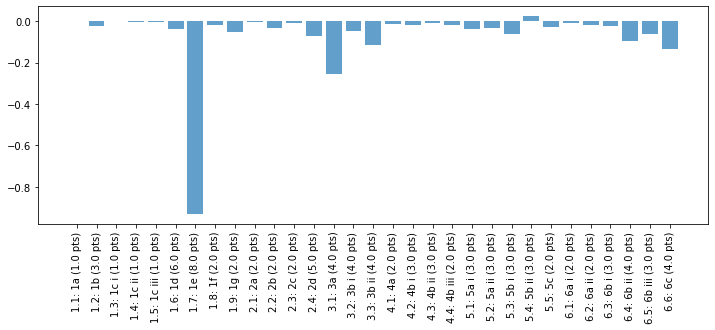

In [661]:
mid1_col_names = mid1_grades.columns

plt.figure(figsize=(12, 4))
plot_pc(mid1_col_names, vt2, 0);

However, if we look at the variance of each individual problem, we see that `problem 1.7: 1e` has a much higher variance than the other problems. After all, PCA is all about identifying the combination of features that best predicts variance.

And in case you're curious, this large variance is partially because this problem is worth a lot of points, but also because this snapshot of the grades was at a time when we had only graded a small number of the 1.7 submissions so lots of people still have a zero.

In [662]:
np.var(mid1_grades)

1.1: 1a (1.0 pts)        0.246582
1.2: 1b (3.0 pts)        0.321965
1.3: 1c i (1.0 pts)      0.026728
1.4: 1c ii (1.0 pts)     0.080010
1.5: 1c iii (1.0 pts)    0.089778
1.6: 1d (6.0 pts)        1.528688
1.7: 1e (8.0 pts)        8.491249
1.8: 1f (2.0 pts)        0.243952
1.9: 1g (2.0 pts)        0.966340
2.1: 2a (2.0 pts)        0.035961
2.2: 2b (2.0 pts)        0.452519
2.3: 2c (2.0 pts)        0.251915
2.4: 2d (5.0 pts)        1.582213
3.1: 3a (4.0 pts)        2.351464
3.2: 3b i (4.0 pts)      0.710237
3.3: 3b ii (4.0 pts)     1.498929
4.1: 4a (2.0 pts)        0.471467
4.2: 4b i (3.0 pts)      0.735016
4.3: 4b ii (3.0 pts)     0.374919
4.4: 4b iii (2.0 pts)    0.313374
5.1: 5a i (3.0 pts)      2.204308
5.2: 5a ii (3.0 pts)     1.388593
5.3: 5b i (3.0 pts)      1.228950
5.4: 5b ii (3.0 pts)     1.497788
5.5: 5c (2.0 pts)        0.422277
6.1: 6a i (2.0 pts)      0.364395
6.2: 6a ii (2.0 pts)     0.230278
6.3: 6b i (3.0 pts)      0.389746
6.4: 6b ii (4.0 pts)     1.732163
6.5: 6b iii (3

One way to prevent having high variance variables from dominating the first principal component is to rescale our data so that each column has unit variance.

Create a data frame `mid1_grades_centered_scaled` such that the means of each column in `mid1_grades_centered` are 0 and their variances are 1.

*Hint:* Consider how dividing a column by $c$ affects the sample variance of that column. Each column will need to be divided by a different number in order to achieve unit variance in that column.

<!--
BEGIN QUESTION
name: q2c
points: 1
-->

In [663]:
mid1_grades_centered_scaled = mid1_centered/ np.std(mid1_centered, axis=0)
mid1_grades_centered_scaled

,1.1: 1a (1.0 pts),1.2: 1b (3.0 pts),1.3: 1c i (1.0 pts),1.4: 1c ii (1.0 pts),1.5: 1c iii (1.0 pts),1.6: 1d (6.0 pts),1.7: 1e (8.0 pts),1.8: 1f (2.0 pts),1.9: 1g (2.0 pts),2.1: 2a (2.0 pts),...,5.2: 5a ii (3.0 pts),5.3: 5b i (3.0 pts),5.4: 5b ii (3.0 pts),5.5: 5c (2.0 pts),6.1: 6a i (2.0 pts),6.2: 6a ii (2.0 pts),6.3: 6b i (3.0 pts),6.4: 6b ii (4.0 pts),6.5: 6b iii (3.0 pts),6.6: 6c (4.0 pts)
0,-1.124651,0.421937,-2.802474,-3.225260,-0.203544,0.569910,-0.162592,0.506160,0.830632,0.095685,...,-0.102655,-1.689079,-1.804702,0.369204,-0.911790,0.277291,0.217987,-0.411309,0.067945,-0.694845
1,-1.124651,0.421937,0.255891,-3.225260,-1.872265,0.569910,-0.505766,0.506160,-1.203903,0.095685,...,-0.951274,1.017085,0.646596,-2.708530,0.744795,0.277291,0.217987,-1.171120,0.067945,-0.694845
2,0.889165,0.421937,0.255891,0.310053,1.465178,0.569910,1.210103,0.506160,0.830632,0.095685,...,-0.102655,0.115030,0.646596,0.369204,0.744795,0.277291,0.217987,1.868124,0.991258,-0.694845
3,-1.124651,-1.340428,0.255891,-3.225260,-0.203544,0.569910,1.553277,0.506160,0.830632,0.095685,...,-0.102655,1.017085,-1.804702,0.369204,-0.911790,0.277291,0.217987,-0.411309,-1.778680,-0.694845
4,0.889165,0.421937,0.255891,0.310053,-0.203544,0.569910,0.866929,-1.518481,-1.203903,0.095685,...,1.594582,0.115030,0.646596,-2.708530,0.744795,0.277291,0.217987,-0.411309,0.067945,1.439169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,-1.124651,0.421937,0.255891,0.310053,1.465178,-1.856487,1.553277,0.506160,0.830632,0.095685,...,-0.951274,-0.787024,-1.804702,0.369204,0.744795,0.277291,0.217987,-0.411309,0.991258,-0.694845
988,0.889165,-0.459245,0.255891,0.310053,-0.203544,-1.047688,-0.848940,0.506160,0.830632,0.095685,...,1.594582,-1.689079,0.646596,0.369204,-0.911790,0.277291,0.217987,-0.411309,0.067945,-0.694845
989,0.889165,0.421937,0.255891,0.310053,-0.203544,-0.238889,-0.505766,-1.518481,0.830632,0.095685,...,-0.102655,-0.787024,0.646596,0.369204,0.744795,0.277291,0.217987,-0.411309,0.991258,-0.694845
990,0.889165,0.421937,0.255891,0.310053,1.465178,-1.047688,0.180581,0.506160,0.830632,0.095685,...,-0.102655,0.115030,0.646596,0.369204,-0.911790,0.277291,0.217987,-0.411309,0.067945,1.439169


In [664]:
grader.check("q2c")

q2c passed!

<!-- BEGIN QUESTION -->

## Question 2d

Create a 2D scatterplot of the first two principal components of `mid1_grades_centered_scaled`. Use `colorize_midterm_data` to add a `color` column to `mid1_1st_2_pcs`. Your code will be very similar to the code from problems 2a and 2b.

<!--
BEGIN QUESTION
name: q2d
manual: true
points: 3
-->

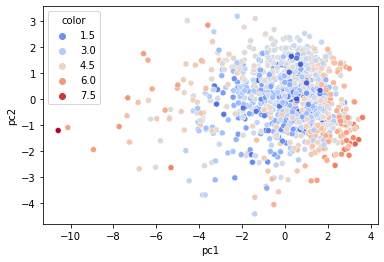

In [665]:
u2d, s2d, vt2d, = np.linalg.svd(mid1_grades_centered_scaled, full_matrices = False)
mid1_2d_1st_2_pcs = pd.DataFrame(u2d*s2d)[[0,1]].rename(columns = {0: 'pc1', 1: 'pc2'})
sns.scatterplot(data = colorize_midterm_data(mid1_2d_1st_2_pcs), x = "pc1", y = "pc2", hue = "color", palette = "coolwarm");

<!-- END QUESTION -->



This scatterplot is quite different. The diagonal banding we saw before is gone.

By looking at the colors, we can also get some sense of how our centering process altered the locations of each student in the 2D PCA scatterplot. Observe that the blue students are still mostly close to each other, and the red points are still largely at the margins. 

This plot shows relatively little structure and has no clusters. There does not appear to be much to learn here.

<!-- BEGIN QUESTION -->

## Question 2e

If you compute the fraction of the variance captured by this 2D scatter plot, you'll see it's only 17%, roughly 12% by the 1st PC, and roughly 5% by the 2nd PC. **In the cell below, create a scree plot showing the fraction of the variance explained by each principle componant using the data from 2d.**

Informally, we can say that our midterm scores matrix has a high rank. More formally, we can say that a rank 2 approximation only captures a small fraction of the variance, and thus the data are not particularly amenable to 2D PCA scatterplotting.

<!--
BEGIN QUESTION
name: q2e
manual: true
points: 2
-->

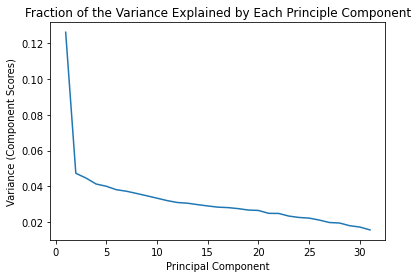

In [666]:
plt.xlabel("Principal Component");
plt.ylabel("Variance (Component Scores)");
plt.title("Fraction of the Variance Explained by Each Principle Component");
plt.plot(np.arange(1,len(s2d)+1),s2d**2/(np.sum(s2d**2)));

<!-- END QUESTION -->



## Question 3

PCA really shines on data where you have reason to believe that the data is relatively low in rank. 

In this final question of the homework, we'll look at how states voted in presidential elections between 1972 and 2016. **Our ultimate goal in question 3 is to show how 2D PCA scatterplots can allow us to identify clusters in a high dimensional dataset.** For this example, that means finding groups of states that vote similarly by plotting their 1st and 2nd principal components.

## Question 3a

Unlike prior assignments, we're going to make you go get the data yourself. Specifically, we'd like you to use this table from Wikipedia: [https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state](https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state). 

You can convert the table into csv format this website: [https://wikitable2csv.ggor.de/](https://wikitable2csv.ggor.de/). Simply paste the URL of the article into wikitable2csv and leave the default options as they are.

Then click download on Table 1, and you should download a file called `table-1.csv`.

Upload this file to the `hw11` folder in your DataHub and rename it `presidential_elections.csv`. Then run the cell below to make sure that you did everything properly.

Since the data about the 2020 election is incomplete, we will drop the 2020 column from our dataframe.



<!--
BEGIN QUESTION
name: q3a
points: 1
-->

In [667]:
df = pd.read_csv("presidential_elections.csv")
df = df.drop('2020', axis=1)
df.head(5)

,State,1789,1792,1796,1800 †,Unnamed: 5,1804,1808,1812,1816,...,1988,1992,1996,2000 ‡,Unnamed: 60,2004,2008,2012,2016 ‡,State.1
0,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,R,R,R,NaN,R,R,R,R,Alabama
1,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,R,R,R,NaN,R,R,R,R,Alaska
2,Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,R,D,R,NaN,R,R,R,R,Arizona
3,Arkansas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,D,D,R,NaN,R,R,R,R,Arkansas
4,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,D,D,D,NaN,D,D,D,D,California


In [668]:
grader.check("q3a")

q3a passed!

## Question 3b

The data in this table is pretty messy. Create a clean version of this table called `df_1972_to_2016`. It should contain exactly 51 rows (corresponding to the 50 states plus Washington DC) and 12 columns (one for each of the election years from 1972 to 2016).

The index of this dataframe should be the state name. The name you pick for the index doesn't matter.

Hint: Our solution uses `iloc`, `drop` (twice), `rename`, and `set_index`.

Hint: Feel free to open your csv file in Excel or Google Slides to explore the data if you find that easier. However, we require that you do your actual data cleaning in pandas, i.e. don't just delete and rename columns in Excel. 

Note: In your personal projects, it is sometimes more convenient to manually do your data cleaning using Excel or Google Sheets. The downside of doing this is that you have no record of what you did, and if you have to redownload the data, you have to redo the manual data cleaning process.

<!--
BEGIN QUESTION
name: q3b
points: 2
-->

In [669]:
df_1972_to_2016_clean = df.iloc[:,-14:].drop(['Unnamed: 60'],axis=1).rename(columns = {'2000 ‡': '2000', '2016 ‡': '2016', 'State.1': 'State'}).drop([25,52]).set_index("State")
df_1972_to_2016_clean

,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016
State,,,,,,,,,,,,
Alabama,R,D,R,R,R,R,R,R,R,R,R,R
Alaska,R,R,R,R,R,R,R,R,R,R,R,R
Arizona,R,R,R,R,R,R,D,R,R,R,R,R
Arkansas,R,D,R,R,R,D,D,R,R,R,R,R
California,R,R,R,R,R,D,D,D,D,D,D,D
Colorado,R,R,R,R,R,D,R,R,R,D,D,D
Connecticut,R,R,R,R,R,D,D,D,D,D,D,D
Delaware,R,D,R,R,R,D,D,D,D,D,D,D
D.C.,D,D,D,D,D,D,D,D,D,D,D,D


In [670]:
grader.check("q3b")

q3b passed!

## Question 3c

To perform PCA, we need to convert our data into numerical values. To do this, replace all of the "D" characters with the number 0, and all of the "R" characters with the number 1. 

*Hint:* Use `df.replace`.

<!--
BEGIN QUESTION
name: q3c
points: 1
-->

In [671]:
df_1972_to_2016_numerical = df_1972_to_2016_clean.replace('D', 0).replace('R', 1)
df_1972_to_2016_numerical

,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016
State,,,,,,,,,,,,
Alabama,1,0,1,1,1,1,1,1,1,1,1,1
Alaska,1,1,1,1,1,1,1,1,1,1,1,1
Arizona,1,1,1,1,1,1,0,1,1,1,1,1
Arkansas,1,0,1,1,1,0,0,1,1,1,1,1
California,1,1,1,1,1,0,0,0,0,0,0,0
Colorado,1,1,1,1,1,0,1,1,1,0,0,0
Connecticut,1,1,1,1,1,0,0,0,0,0,0,0
Delaware,1,0,1,1,1,0,0,0,0,0,0,0
D.C.,0,0,0,0,0,0,0,0,0,0,0,0


In [672]:
grader.check("q3c")

q3c passed!

## Question 3d

Now center the data so that the mean of each column is 0 and scale the data so that the variance of each column is 1. Store your result in `df_1972_to_2016`.

<!--
BEGIN QUESTION
name: q3d
points: 1
-->

In [673]:
df_mean = np.mean(df_1972_to_2016_numerical, axis=0)
df_centered = df_1972_to_2016_numerical - df_mean

df_1972_to_2016 = df_centered / np.std(df_centered, axis=0)
df_1972_to_2016

,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016
State,,,,,,,,,,,,
Alabama,0.202031,-1.060660,0.398862,0.202031,0.524404,1.354006,1.297771,0.836660,0.803219,1.148121,1.060660,0.836660
Alaska,0.202031,0.942809,0.398862,0.202031,0.524404,1.354006,1.297771,0.836660,0.803219,1.148121,1.060660,0.836660
Arizona,0.202031,0.942809,0.398862,0.202031,0.524404,1.354006,-0.770552,0.836660,0.803219,1.148121,1.060660,0.836660
Arkansas,0.202031,-1.060660,0.398862,0.202031,0.524404,-0.738549,-0.770552,0.836660,0.803219,1.148121,1.060660,0.836660
California,0.202031,0.942809,0.398862,0.202031,0.524404,-0.738549,-0.770552,-1.195229,-1.244990,-0.870988,-0.942809,-1.195229
Colorado,0.202031,0.942809,0.398862,0.202031,0.524404,-0.738549,1.297771,0.836660,0.803219,-0.870988,-0.942809,-1.195229
Connecticut,0.202031,0.942809,0.398862,0.202031,0.524404,-0.738549,-0.770552,-1.195229,-1.244990,-0.870988,-0.942809,-1.195229
Delaware,0.202031,-1.060660,0.398862,0.202031,0.524404,-0.738549,-0.770552,-1.195229,-1.244990,-0.870988,-0.942809,-1.195229
D.C.,-4.949747,-1.060660,-2.507133,-4.949747,-1.906925,-0.738549,-0.770552,-1.195229,-1.244990,-0.870988,-0.942809,-1.195229


In [674]:
grader.check("q3d")

q3d passed!

## Question 3e

We now have our data in a nice and tidy centered and scaled format, phew. We are now ready to do PCA.

Create a new dataframe `first_2_pcs` that contains exactly the first two columns of the principal components matrix. The first column should be labeled `pc1` and the second column should be labeled `pc2`. Store your result in `first_2_pcs`.

<!--
BEGIN QUESTION
name: q3e
points: 2
-->

In [675]:
u3, s3, vt3, = np.linalg.svd(df_1972_to_2016, full_matrices = False)
first_2_pcs = pd.DataFrame(u3*s3)[[0,1]].rename(columns = {0: 'pc1', 1: 'pc2'})
first_2_pcs.head()

,pc1,pc2
0,-2.733898,0.878935
1,-2.854135,-0.068869
2,-2.187073,-0.161736
3,-1.399352,0.733236
4,2.117444,-1.848357


In [676]:
grader.check("q3e")

q3e passed!

## Question 3f

The cell below plots the 1st and 2nd principal components of our 50 states + Washington DC.

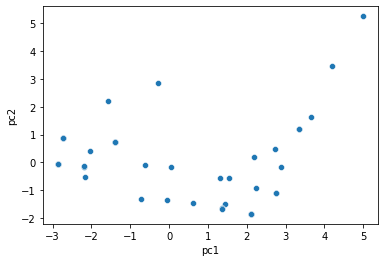

In [677]:
sns.scatterplot(data = first_2_pcs, x = "pc1", y = "pc2");

<!-- BEGIN QUESTION -->

Unfortunately, we have two problems:

1. There is a lot of overplotting, with only 27 distinct dots. This means that at least some states voted exactly alike in these elections.
2. We don't know which state is which because the points are unlabeled.

Let's start by addressing problem 1. 

**In the cell below, create a new dataframe `first_2_pcs_jittered` with a small amount of random noise added to each principal component. In this same cell, create a scatterplot.**

The amount of noise you add should not significantly affect the appearance of the plot, it should simply serve to separate overlapping observations. Don't get caught up on the exact details of your noise generation, it's fine as long as your plot looks roughly the same as the original scatterplot.

*Hint:* See the pairplot from the intro to question 2 for an example of how to introduce noise.

<!--
BEGIN QUESTION
name: q3f
manual: true
points: 2
-->

In [678]:
first_2_pcs_jittered = first_2_pcs + np.random.normal(0, 0.1, size = (len(first_2_pcs), 2));

<!-- END QUESTION -->

## Question 3g

To label our points, the best option is to use the `plotly` library that we used earlier in this homework. `plotly` is an incredibly powerful plotting library that will automatically add axis labels, and will also provide controls so that you can zoom and pan around to look at the data.

One important skill as a user of modern tools is using existing documentation and examples to get the plot you want.

Using the example given on this page as a [guide](https://plot.ly/python/text-and-annotations/), create a scatter plot of your **jittered data** from 3f with the following key properties:

1. Your plot should be created using `px.scatter`, and should use the `fig.update_traces` method to set the `textposition`. 
2. Each point should be labeled by the name of the state, and the label should be above the point.

Unfortunately due to current technological limitations, `plotly` graphs don't show up in our PDF outputs. As a result, this part of the problem (3g part i only) is worth 0 points. With that being said, getting this to work as intended is an excellent exercise in learning how to use `plotly`, and you should still do it. Furthermore, you will need this plot for the remaining parts of the homework.

*Hint*: You can get a list of the state names with `list(df_1972_to_2016.index)`.

*Hint*: `gapminder` in the example linked is just the name of their dataframe. Your code shouldn't have anything to do with `gapminder` since we're plotting presidential election data, not life expectancies and GDP.

<!--
BEGIN QUESTION
name: q3gi
points: 0
-->

### Part i

In [679]:
import plotly.express as px

fig = px.scatter(first_2_pcs_jittered, x='pc1', y='pc2', text = list(df_1972_to_2016.index))
fig.update_traces(textposition = "top center")

### Part ii

<!-- BEGIN QUESTION -->

Give an example of a cluster of states that vote a similar way. Does the composition of this cluster surprise you? If you're not familiar with U.S. politics, it's fine to just say 'No, I'm not surprised because I don't know anything about U.S. politics.'.

<!--
BEGIN QUESTION
name: q3gii
manual: true
points: 1
-->

A cluster of states that vote in similar ways is Kentucky, Tennessee, Missouri, Louisiana, and Arkansas. This does not surprise me since these states have always been known to vote red.

<!-- END QUESTION -->



### Part iii

<!-- BEGIN QUESTION -->

In the cell below, write down anything interesting that you observe by looking at this plot. You will get credit for this as long as you write something reasonable that you can take away from the plot.

<!--
BEGIN QUESTION
name: q3giii
manual: true
points: 1
-->

Something I find interesting in this plot are the distinct states that have no clusters, such as West Virginia and Georgia. I believe that these distinctions can be observed because they have higher rates of being a swing state ie either being red or blue, compared to other states that in clusters, such as the cluster I mentioned in part ii, where the likely hood of their changing colors is quite low.

<!-- END QUESTION -->



## Question 3h

We can also look at the contributions of each year's elections results on the values for our principal components. Below, we use the `plot_pc` function from question 3c to plot the 1st row of $V^T$ in the cell below.

Here by "1st row" we mean the row that is used to generate `pc1`, and by "2nd row" we mean the row that is used to generate `pc2`.

Note: If you want to adjust the size of your plot for a single figure, you can set `plt.figure(figsize=(x, y))` before creating the figure.


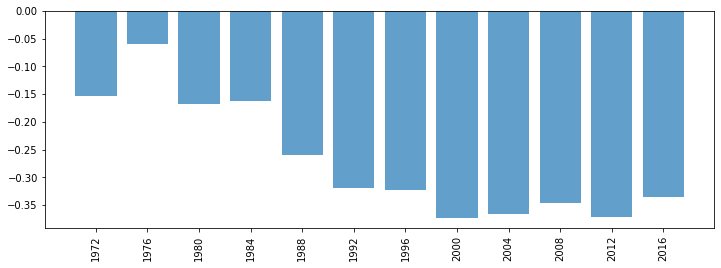

In [680]:
plt.figure(figsize=(12, 4))
plot_pc(list(df_1972_to_2016.columns), vt3, 0);

<!-- BEGIN QUESTION -->

In the cell below, plot the the 2nd row of $V^T$. 

<!--
BEGIN QUESTION
name: q3h
manual: true
points: 1
-->

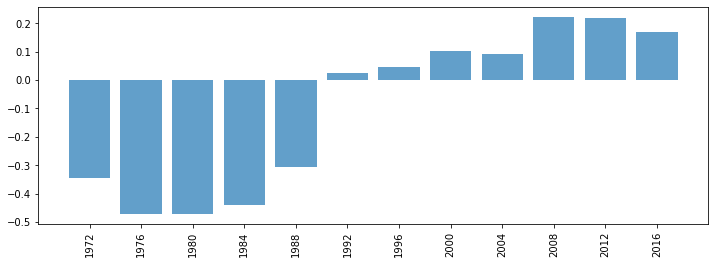

In [681]:
plt.figure(figsize=(12, 4))
plot_pc(list(df_1972_to_2016.columns), vt3, 1);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 3i

Using your plots from question 3h as well as the original table, give a description of what it means to have a relatively large positive value for `pc1` (right side of the 2D scatter plot), and what it means to have a relatively large positive value for `pc2` (top side of the 2D scatter plot).

In other words, what is generally true about a state with relatively large positive value for `pc1`? For a large positive value for `pc2`?

Note: `pc2` is pretty hard to interpret, and the staff doesn't really have a consensus on what it means either. We'll be nice when grading. 

Note: Principal components beyond the first are often hard to interpret (but not always; see question 1 earlier in this homework).

<!--
BEGIN QUESTION
name: q3i
manual: true
points: 2
-->

According to the plots above, having a relatively large positive value for pc1 means that states tended to vote more democratic than republican. Having a relatively large positive value for pc2 means that states have a higher tendency to switch between democratic and republican votes.

<!-- END QUESTION -->

In [682]:
# feel free to use this cell for scratch work. If you need more scratch space, add cells *below* this one.

# Make sure to put your actual answer in the cell above where it says "Type your answer here, replacing this text"

<!-- BEGIN QUESTION -->

## Question 3j

To get a better sense of whether our 2D scatterplot captures the whole story, create a scree plot for this data. On the y-axis plot the fraction of the total variance captured by the ith principal component. You should see that the first two principal components capture much more of the variance than we were able to capture when using the Data 100 Midterm 1 data. It is partially for this reason that the 2D scatter plot was so much more useful for this dataset.

*Hint:* Your code will be very similar to the scree plot from problem 1d. Be sure to label your axes appropriately!

<!--
BEGIN QUESTION
name: q3j
manual: true
points: 2
-->

Text(0.5, 1.0, 'Fraction of Variance Explained by each Principal Component')

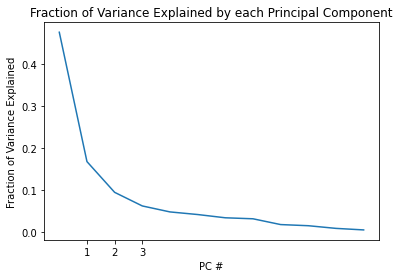

In [683]:
plt.plot(s3**2 / sum(s3**2));
plt.xticks([1, 2, 3], [1, 2, 3]);
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance Explained');
plt.title('Fraction of Variance Explained by each Principal Component')

<!-- END QUESTION -->



## Question 4: Low Rank Approximation

Let's look again at our surfboard data.

In [684]:
surfboard = pd.read_csv("data3d.csv")
surfboard.head(5)

,x,y,z
0,0.005605,2.298191,1.746604
1,-1.093255,2.457522,0.170309
2,0.060946,0.473669,-0.003543
3,-1.761945,2.151108,3.132426
4,1.950637,-0.194469,-2.101949


As we discussed in class, we can compute a low rank approximation of our surfboard data using the code below. 

In [685]:
#compute the means
surfboard_means = np.mean(surfboard, axis = 0)

#find u, s, and vt for centered version of surfboard means
u_q4, s_q4, vt_q4 = np.linalg.svd(surfboard - surfboard_means, full_matrices = False)

#compute the rank 2 approximation of the centered data
rank2_approximation_raw = u_q4[:, 0:2] @ np.diag(s_q4[0:2]) @ vt_q4[0:2, :] 

#add the means back in to the rank 2 approximation, also rename the columns x, y, z
rank2_approximation_df = pd.DataFrame(rank2_approximation_raw, columns = ["x", "y", "z"]) + surfboard_means
rank2_approximation_df.head()

,x,y,z
0,-0.528243,2.426084,1.284617
1,-0.242421,2.253689,0.906612
2,0.092966,0.465998,0.024166
3,-2.000693,2.208305,2.925816
4,1.853212,-0.171129,-2.186260


In [686]:
surfboard_centered.head()

,x,y,z
0,-0.022232,2.264900,1.766968
1,-1.121093,2.424231,0.190672
2,0.033108,0.440379,0.016820
3,-1.789782,2.117818,3.152790
4,1.922799,-0.227760,-2.081586


Looking at the tables, you can see that the rank 2 approximation resembles the centered surfboard data pretty well. It's not perfect, but it does very roughly seem to capture the essence. It turns out that what is happening here is that the data is getting squashed flat in its "thinnest" dimension. 

This is a simple but subtle idea that is really hard to truly understand until you've looked at it visually.

## Question 4a

First, let's see what our data looks like if we zero out our 3rd principal component. 

In the cell below, create `surfboard_1st_2_pcs` which should be exactly like `surfboard_pcs` but with the 3rd column set equal to 0. 

**Note:** Don't edit `surfboard_pcs`, otherwise you'll fail tests when you run the check-all below! You can copy an array using [`np.ndarray.copy`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.copy.html).

<!--
BEGIN QUESTION
name: q4a
points: 1
-->

In [687]:
surfboard_copy = surfboard_centered.copy()
surfboard_1st_2_pcs = surfboard_copy @ vt_q4.T
surfboard_1st_2_pcs[2].values[:] = 0
surfboard_1st_2_pcs = surfboard_1st_2_pcs.rename(columns = {0: 'pc1', 1: 'pc2', 2: 'pc3'})
surfboard_1st_2_pcs

,pc1,pc2,pc3
0,-2.648158,-0.851423,0.0
1,-2.183269,-1.046819,0.0
2,-0.294094,-0.327062,0.0
3,-4.105824,0.817194,0.0
4,2.209110,-1.784578,0.0
...,...,...,...
995,2.803379,-1.434264,0.0
996,-1.127817,1.701696,0.0
997,1.594893,-0.195079,0.0
998,-0.952173,1.395947,0.0


In [688]:
grader.check("q4a")

q4a passed!

We use `colorize_surfboard_data` to add a `color` column to the dataframe. The following plot should show data which looks exactly like the 3D figure given under "Visualizing the Principal Component Matrix", except flattened into the plane given by z = 0.

In [689]:
fig = px.scatter_3d(colorize_surfboard_data(surfboard_1st_2_pcs), x='pc1', y='pc2', z='pc3', range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10],
                   color = 'color', color_continuous_scale = 'RdBu');
fig.show();

## Question 4b

The rank 2 approximation of our data is simply this "flat" version of our projected data rotated back into the original space. 

One way to conceptualize this is that we used $V$ to rotate our data $X$ yielding $P$. Now after flattening $P$, we rotate back.

In the cell below, compute the centered rank 2 approximation using `surfboard_1st_2_pcs`. Store your result in a dataframe in the variable `surfboard_rank2_approximation_centered`. Name your columns `x`, `y`, and `z`.

*Hint*: How can we use $V^T$ or $V$ to rotate $P$ back to $X$?

*Reminder*: Use `df.rename` to rename the columns to be `x`, `y`, and `z`.

<!--
BEGIN QUESTION
name: q4b
points: 2
-->

In [690]:
surfboard_rank2_approximation_centered = surfboard_1st_2_pcs @ vt_q4
surfboard_rank2_approximation_centered = surfboard_rank2_approximation_centered.rename(columns = {0:'x', 1:'y', 2:'z'})

In [691]:
grader.check("q4b")

q4b passed!

In the cell below, we visualize your rank 2 surfboard approximation.

In [692]:
fig = px.scatter_3d(colorize_surfboard_data(surfboard_rank2_approximation_centered), x='x', y='y', z='z', range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10],
                   color = 'color', color_continuous_scale = 'RdBu');
fig.show();

As you can see, the rank 2 approximation is just the original 3D data smashed totally flat in its "thinnest" direction. This idea generalizes to higher dimensions. For example, if we have 20 dimensional data and create the rank 2 approximation, we are simply smashing the data flat in the 18 least important dimensions.

## Question 5: Interpreting Diagonal Banding (Optional)

As an optional exercise, try to figure out why we saw the diagonal bands in the scatterplot from question 2b. One approach is to use `plot_pc` on the 1st and 2nd pc to understand how they're created from the data. The answer is somewhat lame, but you might find the exercise useful.

_Type your answer here, replacing this text._

In [693]:
### Feel free to use these cells for scratch work


---

To double-check your work, the cell below will rerun all of the autograder tests.

In [694]:
grader.check_all()

q1a passed!

q1b passed!

q1c passed!

q1d passed!

q1e passed!

q2a passed!

q2b passed!

q2c passed!

q3a passed!

q3b passed!

q3c passed!

q3d passed!

q3e passed!

q4a passed!

q4b passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()